<a href="https://colab.research.google.com/github/ronald-hk-chung/ComputerVision/blob/main/selective_search_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selective Search for Object Dection R-CNN

### Algorithm Of Selective Search:

Referece: http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

1. Generate initial sub-segmentation of input image using the method describe by Felzenszwalb et al, implimented through ```skimage.segmentation.felzenszwalb``` (Referece: https://cs.brown.edu/people/pfelzens/papers/seg-ijcv.pdf)

2. Recursively combine the smaller similar regions into larger ones using below algorithm
> 1. From set of regions, choose two that are most similar
> 2. Combine them into a single, larger region
> 3. Repeat the above steps for multiple iteration

3. Use the segmented region proposals to generate candidate object locations

###Similarity in Segmentation

*   **Color Similarity**

> For each region we generate the histogram of each channels of colors present in image .In this paper 25 bins are taken in histogram of each color channel. This gives us 75 bins (25 for each R, G and B) and all channels are combined into a vector  (n = 75) for each region. Then we find similarity using equation below:

$$
\mathbf{S}_{\text {color }}\left(r_1, r_j\right)=\sum_{k=1}^n \min \left(c_i^k, r_j^k\right)
$$

*   **Texture Similarity**

> LBP (Local Binary Pattern) is used for texture classification. LBP looks at points surrounding a central point and tests whether the surrounding points are greater than or less than the central point (i.e. gives a binary result). Result is than extracted to a histogram with 10 bins for each color channels. We derive similarity using below equation:

$$
\mathbf{S}_{\text {texture }}\left(r_1, r_j\right)=\sum_{k=1}^n \min \left(c_i^k, r_j^k\right)
$$

*   **Size Similarity**

> The basic idea of size similarity is to make smaller region merge easily. If this similarity is not taken into consideration then larger region keep merging with larger region and region proposals at multiple scales will be generated at this location only.

$$
\mathbf{S}_{size}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)=\mathbf{1}-\left(\operatorname{size}\left(\mathbf{r}_{\mathbf{i}}\right)+\operatorname{size}\left(\mathbf{r}_{\mathbf{j}}\right)\right) \div \operatorname{size}(\mathbf{i m g})
$$

*   **Fill Similarity**

> Fill Similarity measures how well two regions fit with each other. If two region fit well into one another (For Example one region is present in another) then they should be merged, if two region does not even touch each other then they should not be merged.

$$
\mathbf{S}_{\mathbf{f i l l}}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)=\mathbf{1}-\left(\operatorname{size}\left(\mathbf{B B}_{\mathbf{i} \mathbf{j}}\right)-\operatorname{size}\left(\mathbf{r}_{\mathbf{i}}\right)-\operatorname{size}\left(\mathbf{r}_{\mathbf{j}}\right)\right) \div \operatorname{size}(\mathbf{i m g})
$$

$$
\text { size }\left(B B_{i j}\right) \text { is the size of bounding box around } i \text { and } j
$$

*   **Combine similarities to form a final similarity measure**

> Add all similarities measure using below formula:

$$
\mathbf{S}_{\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)}=\mathbf{a}_{\mathbf{1}} * \mathbf{s}_{\text {color }}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)+\mathbf{a}_{\mathbf{2}} * \mathbf{s}_{\text {texture }}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)+\mathbf{a}_3 * \mathbf{s}_{\text {size }}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)+\mathbf{a}_{\mathbf{4}} * \mathbf{s}_{\text {fill }}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)
$$
where $a_i$ is either 0 or 1 depending upon we consider this similarity or not .


### Reference:

https://www.geeksforgeeks.org/selective-search-for-object-detection-r-cnn/

http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

http://vision.stanford.edu/teaching/cs231b_spring1415/slides/ssearch_schuyler.pdf

## Downloading an image for testing

In [1]:
import requests
url = 'https://cdn.britannica.com/86/166986-050-4CEFE5DE/cute-kitten-and-puppy-outdoors-in-grass.jpg'
r = requests.get(url)
with open('test.jpg', 'wb') as f:
  f.write(r.content)

## Importing TorchStep and relevant packages

In [2]:
# Clone TorchStep
!git clone https://github.com/ronald-hk-chung/TorchStep
!sh TorchStep/config.sh

Cloning into 'TorchStep'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 35 (delta 13), reused 31 (delta 9), pack-reused 0
Receiving objects: 100% (35/35), 14.20 KiB | 2.03 MiB/s, done.
Resolving deltas: 100% (13/13), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 16.1 MB/s eta 0:00:00


In [7]:
from PIL import Image
from TorchStep.vision_utils import SelectiveSearch
from TorchStep.vision_utils import show

In [6]:
img = Image.open('test.jpg').convert('RGB')
img_search = SelectiveSearch(img=img, scale=1, min_size=100)

In [8]:
bbs = img_search.search(size_thresold=0.05)

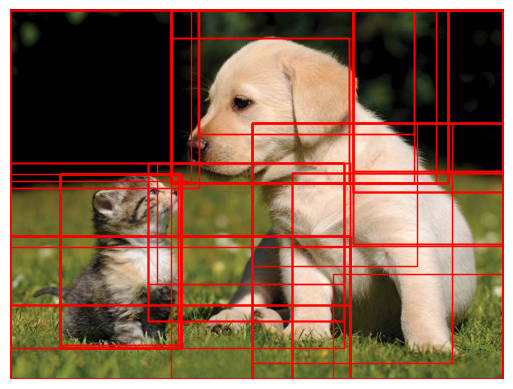

In [9]:
show(img, bbs)

## Code for Selective Search

In [ ]:
import skimage
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class SelectiveSearch:
  """Class performing Selective Search on image

  Args:
    scale [float]: Free parameter. Higher means larger clusters in felzenszwalb segmentation
    sigma [float]: Width of Gaussian kernel for felzenszwalb segmentation
    min_size [int]: Minimum component size for felzenszwalb segmentation

  Methods:
    search(size_thresold=0.05): return list of bounding boxes as [x, y, w, h]

  """
  __slot__ = ['regions']
  def __init__(self,
               img: PIL.Image.Image,
               scale: float = 1.0,
               sigma: float = 0.8,
               min_size: float = 100):
    self.img = np.array(img)
    self.scale = scale
    self.sigma = sigma
    self.min_size = min_size
    self.imsize = self.img.shape[0] * self.img.shape[1]
    self.im_mask = skimage.segmentation.felzenszwalb(image=skimage.util.img_as_float(self.img),
                                                  scale=self.scale,
                                                  sigma=self.sigma,
                                                  min_size=self.min_size)
    self.hsv = skimage.color.rgb2hsv(self.img)
    self.lbp = self.calc_texture_gradient()
    self.R = self.extract_region()
    self.neighbours = self.extract_neighbours()
    self.regions = self.hierarchal_search()

  def extract_region(self):
    R = {}
    # Generate initial sub-segmentation of input image using the method describe by Felzenszwalb
    for y in range(self.im_mask.shape[0]):
      for x in range(self.im_mask.shape[1]):
        if (l := self.im_mask[y][x]) not in R:
          R[l] = {'min_x': 0xffff, 'min_y': 0xffff, 'max_x': 0, 'max_y': 0, 'labels': [l]}
        if R[l]['min_x'] > x: R[l]['min_x'] = x
        if R[l]['min_y'] > y: R[l]['min_y'] = y
        if R[l]['max_x'] < x: R[l]['max_x'] = x
        if R[l]['max_y'] < y: R[l]['max_y'] = y

    # Calculate colour and texture histogram for each region
    for l, v in list(R.items()):
      mask = self.im_mask == l
      R[l]['size'] = mask.sum()
      R[l]['hist_c'] = self.calc_colour_hist(mask)
      R[l]['hist_t'] = self.calc_texture_hist(mask)
    return R

  def calc_texture_gradient(self):
    """
    Calculate texture gradient for image using LBP
    Reference: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.local_binary_pattern
    """
    ret = np.zeros(self.img.shape)
    for colour_channel in range(self.img.shape[2]):
      ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(image=self.img[:, :, colour_channel],
                                                                      P=8, # Number of circularly symmetric neighbor set points (quantization of the angular space)
                                                                      R=1.0) # Radius of circle (spatial resolution of the operator)
    return ret

  def calc_colour_hist(self, mask):
    """
    Calculate color histogram for each region
    The output will be an array with n_BINS * n_color_channels
    Extract from HSV
    """
    BINS = 25
    hist = np.array([])
    for colour_channel in range(self.img.shape[2]):
      layer = self.hsv[:, :, colour_channel][mask]
      hist = np.concatenate([hist] + [np.histogram(layer, BINS, (0.0, 255.0))[0]])
    # L1 normalize
    hist = hist / np.sum(hist)
    return hist

  def calc_texture_hist(self, mask):
    """Calculate texture histogram for each region
    Use LBP (AlpacaDB's implimentation)
    """
    BINS = 10
    hist = np.array([])
    for colour_channel in range(self.img.shape[2]):
      layer = self.lbp[:, :, colour_channel][mask]
      hist = np.concatenate([hist] + [np.histogram(layer, BINS, (0.0, 255.0))[0]])
    # L1 normalize
    hist = hist / np.sum(hist)
    return hist

  def extract_neighbours(self):
    def intersect(a, b):
      if (
          (a['min_x'] < b['min_x'] < a['max_x'] and a['min_y'] < b['min_y'] < a['max_y']) or
          (a["min_x"] < b["max_x"] < a["max_x"] and a["min_y"] < b["max_y"] < a["max_y"]) or
          (a["min_x"] < b["min_x"] < a["max_x"] and a["min_y"] < b["max_y"] < a["max_y"]) or
          (a["min_x"] < b["max_x"] < a["max_x"] and a["min_y"] < b["min_y"] < a["max_y"])
          ):
        return True
      return False

    R = list(self.R.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
      for b in R[cur + 1:]:
        if intersect(a[1], b[1]):
          neighbours.append((a,b))
    return neighbours

  def calc_sim(self, r1, r2):
    """
    Calculate similarity between region ri and rj using diverse
    combinations of similarity measures.
    """
    sim_colour = self.calc_sim_colour(r1, r2)
    sim_texture = self.calc_sim_texture(r1, r2)
    sim_size = self.calc_sim_size(r1, r2)
    sim_fill = self.calc_sim_fill(r1, r2)
    return sim_colour + sim_texture + sim_size + sim_fill

  def calc_sim_colour(self, r1, r2):
    """Calculate the sum of hisogram intersection of colour"""
    return np.minimum(r1['hist_c'], r2['hist_c']).sum()

  def calc_sim_texture(self, r1, r2):
    """Calculate texture similarity using histogram intersection"""
    return np.minimum(r1['hist_t'], r2['hist_t']).sum()

  def calc_sim_size(self, r1, r2):
    """
    Size similarity boosts joint between small regions, which prevents
    a single region from engulfing other blobs one by one.
    size (ri, rj) = 1 − [size(ri) + size(rj)] / size(image)
    """
    return 1.0 - (r1['size'] + r2['size']) / self.imsize

  def calc_sim_fill(self, r1, r2):
    """
    Fill similarity measures how well ri and rj fit into each other.
    BBij is the bounding box around ri and rj.
    fill(ri, rj) = 1 − [size(BBij) − size(ri) − size(ri)] / size(image)
    """
    x_fill = max(r1['max_x'], r2['max_x']) - min(r1['min_x'], r2['min_x'])
    y_fill = max(r1['max_y'], r2['max_y']) - min(r1['min_y'], r2['min_y'])
    bbsize = x_fill * y_fill
    return 1.0 - (bbsize - r1['size'] - r2['size']) / self.imsize

  def merge_regions(self, r1, r2):
    ret = {'min_x': min(r1['min_x'], r2['min_x']),
           'min_y': min(r1['min_y'], r2['min_y']),
           'max_x': max(r1['max_x'], r2['max_x']),
           'max_y': max(r1['max_y'], r2['max_y']),
           'size': r1['size'] + r2['size'],
           'hist_c': (r1['hist_c'] * r1['size'] + r2['hist_c'] * r2['size']) / (r1['size'] + r2['size']),
           'hist_t': (r1['hist_t'] * r1['size'] + r2['hist_t'] * r2['size']) / (r1['size'] + r2['size']),
           'labels': r1['labels'] + r2['labels']}
    return ret

  def hierarchal_search(self):
    # calculate initial similarities
    S = {}
    for (ai, ar), (bi, br) in self.neighbours:
      S[(ai, bi)] = self.calc_sim(ar, br)
    # hierarchal search
    while S != {}:
      # get highest similarity
      i, j = sorted(S.items(), key=lambda x: x[1])[-1][0]
      # merge corresponding regions
      t = max(self.R.keys()) + 1.0
      self.R[t] = self.merge_regions(self.R[i], self.R[j])
      # mark similarities for regions to be removed
      key_to_delete = [k for k, v in list(S.items()) if (i in k) or (j in k)]
      # remove old similarities of related regions
      for k in key_to_delete:
        del S[k]
      # calculate similary set with the new region
      for k in filter(lambda x: x != (i, j), key_to_delete):
        n = k[1] if k[0] in (i, j) else k[0]
        S[(t, n)] = self.calc_sim(self.R[t], self.R[n])
    regions = []
    for k, r in list(self.R.items()):
      regions.append({'rect': (r['min_x'],
                               r['min_y'],
                               r['max_x'] - r['min_x'],
                               r['max_y'] - r['min_y']),
                      'size': r['size'],
                      'labels': r['labels']})
    return regions

  def search(self, size_thresold: float = 0.05):
    """Method to perform selective search

    Args:
      size_thresold [float]: thresold as percentage of image

    Return:
      candidates [list]: list of bounding boxes as [x, y, w, h]
    """
    candidates = []
    for r in self.regions:
      if r['rect'] in candidates: continue
      if r['size'] < (size_thresold * self.imsize): continue
      if r['size'] > self.imsize: continue
      candidates.append(list(r['rect']))
    return candidates

def show(img, bbs=None):
  """Plot image

  Args:
    img [PIL.Image]: image to show
    bbs [list]: list bounding boxes of [(x, y, w, h)]
  """
  fig, ax = plt.subplots()
  ax.imshow(img)
  if bbs is not None:
    for bb in bbs:
      x, y, w, h = bb
      rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
  plt.axis(False)
  plt.show()
